# Parametrsiation of the DART Radiative Transfer Model based on Terrestrial Lidar Scanning. 
## PAR SENSORS Simulation

Voxelized foliage (AMAPvox R Package), Wavefront .obj files of the bark,their respective coordinates (and a DTM) are necesary.
This script simulates PAR sensors in a DART scene. 
for one scene with voxelized foliage and one with discrete objects.

In [1]:
# import all the thing
import pytools4dart as ptd
from multiprocessing import cpu_count
import rasterio as rio
from rasterio.plot import show
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import re
import shutil
import time
import ephem
import math
from datetime import datetime, timedelta

#### Defining all user functions:

In [2]:
def modify_voxel_pos(input_file, output_file, new_min_corner):
    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    # Find the lines containing min and max corners
    min_corner_line = None
    max_corner_line = None

    for i, line in enumerate(lines):
        if line.startswith("#min_corner"):
            min_corner_line = i
        elif line.startswith("#max_corner"):
            max_corner_line = i

    if min_corner_line is None or max_corner_line is None:
        print("Error: Could not find min or max corner in the header.")
        return

    # Extract current min and max corners from their respective lines
    current_min_corner = list(map(float, lines[min_corner_line].strip().split("(")[1].split(")")[0].split(",")))
    current_max_corner = list(map(float, lines[max_corner_line].strip().split("(")[1].split(")")[0].split(",")))

    # Calculate the new max corner
    dimensions = [new_min_corner[i] - current_min_corner[i] for i in range(3)]
    new_max_corner = [current_max_corner[i] + dimensions[i] for i in range(3)]

    # Update the min and max corner lines with new values
    lines[min_corner_line] = f"#min_corner:({','.join(map(str, new_min_corner))})\n"
    lines[max_corner_line] = f"#max_corner:({','.join(map(str, new_max_corner))})\n"

    # Write the modified content to the output file
    with open(output_file, 'w') as outfile:
        outfile.writelines(lines)


def add_inside_sensors_fish(xml_file, df, center, pixel_size=10, res=0.2, z_zero=False):
    # Load XML file of PHASE module
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Find SensorImageSimulation node within Phase
    sensor_image_simulation = root.find("./Phase/SensorImageSimulation")

    # Create Sensor elements based on DataFrame data
    for index, row in df.iterrows():
        # Get the sensor name from the "Name" column
        sensor_name = row['Name']

        sensor = ET.SubElement(sensor_image_simulation, "Sensor", {
            "autoCropImage": "0",
            "autoFOV": "0",
            "customImageName": "1",
            "keepOnlyCentralScene": "0",
            "sensorConfiguration": "0",
            "sensorDisabled": "0",
            "sensorName": sensor_name
        })

        common_config = ET.SubElement(sensor, "SensorCommonConfiguration", {"directionDefinition": "1"})
        sensor_orientation = ET.SubElement(common_config, "SensorOrientation", {"orientationAngle": "0.0"})
        
        # Adjust z-coordinate based on z_zero parameter
        if z_zero:
            z_value = 0
        else:
            z_value = row['Z']
        
        sensor_position = ET.SubElement(common_config, "SensorPosition", {
            "sensorPosX": str(row['X']),
            "sensorPosY": str(row['Y']),
            "sensorPosZ": "0.1",
            "sensorPositionDefinition": "1"
        })
        
        sensor_view = ET.SubElement(common_config, "SensorView", {"viewDefinition": "1"})
        ET.SubElement(sensor_view, "SensorAngleDirection", {
            "sensorDirectionPhi": "0",
            "sensorDirectionTheta": "180"
        })

        ET.SubElement(sensor, "SensorLuxCoreParameters", {"targetRayDensityPerPixel": "50"})

        hemisphere = ET.SubElement(sensor, "Hemisphere")
        ET.SubElement(hemisphere, "ZenithalRange", {"zenithMaximum": "20", "zenithMinimum": "0"})
        ET.SubElement(hemisphere, "HemisphereImageResolution", {"nbPixelsPerAxis": str(pixel_size), "projectionMode": "0"})
        ET.SubElement(hemisphere, "SphereGeometry", {"radius": "0.1"})

        custom_image_name = ET.SubElement(sensor, "SensorImageName", {"imageName":sensor_name})
        

    # Write the updated XML to a new file
    tree.write(xml_file, xml_declaration=True)



def add_inside_sensors_perspective(xml_file, df, center, pixel_size=10, res=0.2, z_zero=False):
    # Load XML file of PHASE module
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Find SensorImageSimulation node within Phase
    sensor_image_simulation = root.find("./Phase/SensorImageSimulation")

    # Ensure the SensorImageSimulation element has the correct attribute
    sensor_image_simulation.set("importMultipleSensors", "0")

    # Create Sensor elements based on DataFrame data
    for index, row in df.iterrows():
        # Get the sensor name from the "Name" column
        sensor_name = row['Name']

        sensor = ET.SubElement(sensor_image_simulation, "Sensor", {
            "autoCropImage": "0",
            "autoFOV": "0",
            "customImageName": "1",
            "keepOnlyCentralScene": "0",
            "sensorConfiguration": "0",
            "sensorDisabled": "0",
            "sensorName": sensor_name
        })

        common_config = ET.SubElement(sensor, "SensorCommonConfiguration", {"directionDefinition": "1"})
        sensor_orientation = ET.SubElement(common_config, "SensorOrientation", {"orientationAngle": "0.0"})

        # Adjust z-coordinate based on z_zero parameter
        if z_zero:
            z_value = 0
        else:
            z_value = row['Z']

        sensor_position = ET.SubElement(common_config, "SensorPosition", {
            "sensorPosX": str(row['Y']),
            "sensorPosY": str(row['X']),
            "sensorPosZ": "0.2",
            "sensorPositionDefinition": "1"
        })

        ET.SubElement(common_config, "CameraTarget", {
                "targetX": str(row['Y']),
                "targetY": str(row['X']),
                "targetZ": "0.0"
            })

        ET.SubElement(sensor, "SensorLuxCoreParameters", {"targetRayDensityPerPixel": "50"})
        ET.SubElement(sensor, "SensorImageName", {"imageName": sensor_name})

        pinhole = ET.SubElement(sensor, "Pinhole", {"fieldOfViewDefinition": "0"})
        ET.SubElement(pinhole, "SensorDimensions", {"height": "0.05", "width": "0.05"})
        ET.SubElement(pinhole, "FocaleDistance", {"focaleDistance": "0.1"})
        ET.SubElement(pinhole, "FieldOfView", {
            "aovHeight": "28.072486935852954",
            "aovWidth": "28.072486935852954"
        })
        ET.SubElement(pinhole, "ImageResolution", {
            "nbPixelsHeight": "1",
            "nbPixelsWidth": "1"
        })

    # Write the updated XML to a new file
    tree.write(xml_file, xml_declaration=True)

def mirror_points_in_dataframe(df, center):
    mirrored_df = df.copy()  # Create a copy of the original DataFrame
    
    # Mirror X and Y coordinates around the center point
    mirrored_df['X'] = center[0] + (center[0] - df['X'])
    mirrored_df['Y'] = center[1] + (center[1] - df['Y'])
    
    return mirrored_df

def calculate_sun_position_sequence(latitude, longitude, start_time, end_time, interval_minutes):
    observer = ephem.Observer()
    observer.lat = str(latitude)  # Latitude in degrees
    observer.long = str(longitude)  # Longitude in degrees

    current_time = start_time
    sun_positions = []

    while current_time <= end_time:
        observer.date = current_time.strftime("%Y/%m/%d %H:%M:%S")

        sun = ephem.Sun(observer)
        sun.compute(observer)

        altitude = math.degrees(sun.alt)
        azimuth = math.degrees(sun.az)

        sun_positions.append((current_time, altitude, azimuth))

        current_time += timedelta(minutes=interval_minutes)

    return sun_positions

def move_the_sun(altitude, azimuth, simu_path):
    xml_file_path = os.path.join(simu_path, 'input/directions.xml')  # Update with the path to your XML file
    
    # Parse the XML tree
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Find the SunViewingAngles element and update its attributes
    sun_viewing_angles = root.find(".//SunViewingAngles")
    sun_viewing_angles.set("sunViewingAzimuthAngle", str(azimuth))
    sun_viewing_angles.set("sunViewingZenithAngle", str(altitude))
    
    # Save the changes to the XML file
    tree.write(xml_file_path)

def save_sensor_data(simu_path, index):
    global total_elapsed_time  # Declare total_elapsed_time as global
    
    total_start_time = datetime.now()  # Record the total start time
    
    # Remove the existing output folder if it exists
    output_folder_path = os.path.join(simu_path, 'output')
    if os.path.exists(output_folder_path):
        shutil.rmtree(output_folder_path)
    
    # Run the simulation for the current time
    simu.run.full()
    
    # New name for the output folder with index
    new_output_folder_name = f'output_{index}'
    
    # Path to the new output folder
    new_output_folder_path = os.path.join(simu_path, new_output_folder_name)
    
    # Copy the entire output folder to the new location
    shutil.copytree(output_folder_path, new_output_folder_path)
    
    total_end_time = datetime.now()  # Record the total end time
    elapsed_time = (total_end_time - total_start_time).total_seconds()  # Calculate the total elapsed time
    total_elapsed_time += elapsed_time  # Accumulate the total elapsed time
    
    print(f'Output folder copied with index: {index}. Total time taken so far: {total_elapsed_time:.2f} seconds')

def save_sensor_data_old(simu_path, index):
    global total_elapsed_time  # Declare total_elapsed_time as global
    
    total_start_time = datetime.now()  # Record the total start time
       
    # Remove the existing output folder if it exists
    output_folder_path = os.path.join(simu_path, 'output')
    if os.path.exists(output_folder_path):
        shutil.rmtree(output_folder_path)
    
    # Run the simulation for the current time
    simu.run.full()
    
    # Path to the output file containing the values
    output_file_path = os.path.join(simu_path, 'output/simulation.properties.txt')
    
    # Read the relevant values from the output file
    relevant_values = []
    with open(output_file_path, 'r') as file:
        for line in file:
            if "image" in line and "ITERX.band0.irradiance" in line:
                relevant_values.append(line.strip())
    
    # Path to save the values for the current time
    output_values_path = os.path.join(simu_path, f'sensor_data_time_{index}_values.txt')
    
    # Write the relevant values to the output file
    with open(output_values_path, 'w') as file:
        file.write('\n'.join(relevant_values))
    
    total_end_time = datetime.now()  # Record the total end time
    elapsed_time = (total_end_time - total_start_time).total_seconds()  # Calculate the total elapsed time
    total_elapsed_time += elapsed_time  # Accumulate the total elapsed time
    
    print(f'Values for time {index} saved. Total time taken so far: {total_elapsed_time:.2f} seconds')

def read_sensor(path, plot=True, size=(50, 50), sensor_df=None, scene_size_x=50, scene_size_y=50, res=0.2):
    # Read binary data from the file
    with open(path, 'rb') as file:
        data = np.fromfile(file, dtype=np.float64)
    
    # Determine the number of rows and columns
    rows, cols = size
    
    # Reshape the data into a matrix
    mat = np.reshape(data, (rows, cols))
    
    # Plot the raster if desired
    if plot:
        plt.imshow(mat, cmap='gray')
        plt.colorbar()
        
        # Plot sensor positions if provided
        if sensor_df is not None:
            plt.scatter(sensor_df['X'] / res, sensor_df['Y']/ res, marker='o', color='red', label='Sensor Positions')
            for i, txt in enumerate(sensor_df['Name']):
                plt.annotate(txt, (sensor_df['X'].iloc[i]/ res, sensor_df['Y'].iloc[i]/ res -2), fontsize=8,color= "lime")
        
        plt.legend()
        plt.show()
    return mat

def nadir_sensor_size(metadata_path):
    with open(metadata_path, 'r') as file:
        metadata = file.read()

    # Split metadata into lines and find the line containing the size information
    metadata_lines = metadata.split('\n')
    size_x = size_y = None
    for line in metadata_lines:
        if line.strip().startswith('Size='):
            size_info = line.strip().split('=')[1]
            size_values = size_info.split()
            size_x = int(size_values[0])
            size_y = int(size_values[1])
            break

    return size_x, size_y

def datetime_sequence(start_time, end_time, interval_minutes):
    current_time = start_time
    sequence = []
    while current_time < end_time:
        sequence.append(current_time)
        current_time += timedelta(minutes=interval_minutes)
    return sequence

def change_hour(xml_path, new_hour, new_minute, new_second):
    # Parse the original XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Modify the attributes
    exact_date_hour = root.find('.//ExactDateHour')
    exact_date_hour.attrib['hour'] = str(new_hour)
    exact_date_hour.attrib['minute'] = str(new_minute)
    exact_date_hour.attrib['second'] = str(new_second)
    
    # Save the modified XML content to the new path
    tree.write(xml_path)

#### Create a "base" DART scene which later will be run for sequence of sun angles

In [11]:
simulation_name = 'Mockup'
simu = ptd.simulation(simulation_name, empty= True) # create simulation
scene_size_x = 20                   # set scene dimension
scene_size_y = 20
simu.scene.size = [scene_size_x, scene_size_y]
res_scene = 0.2
simu.scene.cell = [res_scene, res_scene]                  # set cell size (only relevant if you use the radiative budget function )
sensor_res= 0.05
simu.sensor.pixel_size=sensor_res              # for nadir images 

for wvl in [0.55]:
    simu.add.band(wvl=wvl, bw=0.3)             # create a spectral band with specific wavelength (here PAR over one band 400-700)

simu.core.maket.set_nodes(latitude=48.00087305, longitude=7.80030941) #gps coordinates for sun location (hier Dietenbach)
simu.core.directions.set_nodes(exactDate=1, timezone =0, localTime =1, year=2023, month=8, day=10, hour=13, mode=1, nbPointsOnSphere=4)   
simu.core.phase.Phase.AtmosphereRadiativeTransfer.set_nodes(TOAtoBOA=0)
simu.write(overwrite=True)


Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...


In [12]:
# Define Atmosphere model
simu.core.atmosphere.Atmosphere.set_nodes(aerosolCumulativeModelName="RURALV23",
                                          aerosolsModelName="MIDLATSUM_RURALV23",
                                          hgParametersModelName="RURALV23")

simu.core.atmosphere.Atmosphere.set_nodes(gasCumulativeModelName="MIDLATSUM", gasModelName="MIDLATSUM", temperatureModelName="MIDLATSUM")

#atmosphere radiative transfer



In [13]:
# get path for config files
simu_path = simu.simu_dir
phase_xml_file_path = os.path.join(simu_path, 'input', 'phase.xml')


#### Optical properties

In [14]:
# define optical properties
op_ground = {'type': 'Lambertian',
             'ident': 'ground',
             'databaseName': 'lambertian_vegetation.db',ww
             'ModelName': 'citrus_orchad_ground'}

op_target = {'type': 'Lambertian',
             'ident': 'target',
             'databaseName': 'lambertian_mineral.db',
             'ModelName': 'perfect_lambertian'}

op_trunk = {'type': 'Lambertian',
            'ident': 'trunk',
            'databaseName': 'Lambertian_vegetation.db',
            'ModelName': 'bark_deciduous'}

op_foliage = {'type': 'Lambertian',
            'ident': 'leaf',
            'databaseName': 'Lambertian_vegetation.db',
            'ModelName': 'leaf_deciduous'}

simu.add.optical_property(**op_ground)
simu.scene.ground.OpticalPropertyLink.ident = 'ground'
simu.add.optical_property(**op_target)
simu.add.optical_property(**op_trunk)
simu.add.optical_property(**op_foliage)


#### ADD TREE OBJ

In [15]:
# add tree obj
obj_file_path = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/3D_objects/final_merged/apple_tree.obj"
# Read OBJ file using OBJtools
obj_tree = ptd.OBJtools.objreader(obj_file_path)

# Get center and dimensions of the object
center = obj_tree.center
dim = obj_tree.dims

# Calculate offsets so the object center is in scene center
#x
center_x = center[0]
pos_offset_x = scene_size_x*0.5 - center_x 

#y
center_y = center[1]
pos_offset_y = scene_size_y*0.5 - center_y 

#z
center_z = center[2]
pos_offset_z = dim[2]*0.5 - center_z 


print("Object Dimensions:", dim)
print("Object Center:", center)
print("Offset X:", pos_offset_x)
print("Offset Y:", pos_offset_y)
print("Offset Z:", pos_offset_z)
# add .obj
tree = simu.add.object_3d(obj_file_path, xpos=pos_offset_x, zpos=pos_offset_z, ypos=pos_offset_y, xscale=1, yscale =1, zscale=1)
tree.Groups.Group[0].GroupOpticalProperties.doubleFace = 1
tree.Groups.Group[1].GroupOpticalProperties.doubleFace = 1 
tree.Groups.Group[0].set_nodes(ident = 'leaf') # set both forward and backward properties ident
tree.Groups.Group[1].set_nodes(ident = 'trunk')
tree.objectDEMMode = 2
simu.write(overwrite=True)

Object Dimensions: (7.708799999999999, 9.2578, 6.059199999999999)
Object Center: (9.076699999999999, -1.3728000000000002, 2.017500000000002)
Offset X: 0.9233000000000011
Offset Y: 11.3728
Offset Z: 1.0120999999999976
Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...


In [8]:
# Path to CSV file and target object
sensor_positions_path = r"P:\Patrick\01_Apfelbaum_Radiative_Transfer\par_sensoren\label_x_y_z_pcrs.csv"

#sensor_positions_path = r"P:\Patrick\01_Apfelbaum_Radiative_Transfer\par_sensoren\par_sensor_positionen.csv"
target_obj_path = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/par_sensoren/target_test.obj"
pos_offset_x_inv = scene_size_x*0.5 - (-center_x)


# Read CSV into a pandas DataFrame and apply coordinate offsets (x <-> y and invert y, likely ther is a better way for this)
sensor_positions = pd.read_csv(sensor_positions_path)
sensor_positions['X'] = sensor_positions['X'].astype(float) + pos_offset_y 
sensor_positions['Y'] = (scene_size_x*0.5 - (sensor_positions['Y'].astype(float)+ pos_offset_x_inv ) + scene_size_x*0.5) #invert axis
sensor_positions['Z'] = sensor_positions['Z'].astype(float) + pos_offset_z 

# Create dictionary for the target_objects
targets = {}

# add target objects to scene
for index, row in sensor_positions.iterrows():
    name = row["Name"]
    x_inv = row["Y"]
    y = row["X"]
    z = 0.01
    target = simu.add.object_3d(target_obj_path, xpos=x_inv, zpos=z, ypos=y, xscale=.5, yscale=.5, zscale=1, name=name)
    target.ObjectOpticalProperties.set_nodes(ident='target')
    target.objectDEMMode = 2
    targets[name] = target
    

# Write the simulation
simu.write(overwrite=True)

Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...


In [16]:
# # add the DTM file
# dtm_file = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/DTM/DTMnew.txt"
# dtm_obj_out_path = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/DTM/DTMnew.obj"

# ptd.OBJtools.dtm2obj(dtm = dtm_file,
#                 obj = dtm_obj_out_path)

# Read DTM file using OBJtoolsp
# dtm_obj = ptd.OBJtools.objreader(dtm_obj_out_path)

# read dtm file to scene
# dtm = simu.add.object_3d(dtm_obj_out_path, xpos=pos_offset_y, zpos=pos_offset_z, ypos=pos_offset_x_inv, xscale=1, yscale =1, zscale=1)
# dtm.objectDEMMode = 1
# dtm.ObjectOpticalProperties.set_nodes(ident = 'ground')
# simu.write(overwrite=True)

### Sensor products setup

In [21]:
# # for radiative budget if needed (will take veeeery long with dart lux)
# simu.core.phase.Phase.DartProduct.dartModuleProducts.CommonProducts.set_nodes(radiativeBudgetProducts=1)
# simu.core.phase.Phase.DartProduct.dartModuleProducts.CommonProducts.set_nodes(budget3DParType=1, backEntry=0, backExit=0, bottomEntry=0, bottomExit=0, emitted=0, frontEntry=0, frontExit=0, intercepted=0, leftEntry=0, leftExit=0, rightEntry=0, rightExit=0, scattered=0, topEntry=0, topExit=0, totalEntry=1, totalExit=1)
# simu.write(overwrite = True)

In [17]:
# change brf product type to also include radiance not just reflectance
tree = ET.parse(phase_xml_file_path)
root = tree.getroot()
element = root.find(".//BrfProductsProperties[@luminanceProducts]")
if element is not None:
        element.set('luminanceProducts', '1')

# irradiance is calculated for brf products (3 = industry standard )
element2 = root.find(".//BrfProductsProperties[@projection]")
if element2 is not None:
    element2.set('projection', '3')

tree.write(phase_xml_file_path)

In [18]:
#run base simulation once (this has to happen to later add the sensors, dont know why)
simu.run.full()

True

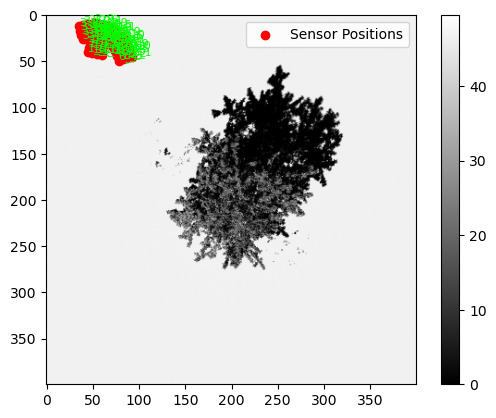

array([[46.79376473, 46.76509367, 46.75327465, ..., 46.76144341,
        46.76097018, 46.78577648],
       [46.83455024, 46.76194171, 46.76726505, ..., 46.75926311,
        46.82415227, 46.76589237],
       [46.80566263, 46.79012094, 46.74779517, ..., 46.83771522,
        46.862157  , 46.83137683],
       ...,
       [46.75869624, 46.80380162, 46.75626025, ..., 46.76154307,
        46.77975919, 46.7976611 ],
       [46.77178895, 46.77339567, 46.81524136, ..., 46.76801494,
        46.78574405, 46.80553811],
       [46.77836803, 46.80732439, 46.75520385, ..., 46.76381951,
        46.76044216, 46.7647092 ]])

In [19]:
#check scene overview (nadir radiance view + sensors positions)
n_sens_size = nadir_sensor_size(os.path.join(simu_path, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
read_sensor(os.path.join(simu_path, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x = scene_size_x, scene_size_y = scene_size_y, res = sensor_res)

In [17]:
# add sensors
add_inside_sensors_perspective(phase_xml_file_path, sensor_positions, center=(0.5*scene_size_x,0.5*scene_size_y), pixel_size = 1)

## Running the simulation

In [35]:
# create the time sequence for the simulation
start_time = datetime(2023, 8, 10, 10, 1, 0)  # Start time in UTC
end_time = datetime(2023, 8, 10, 15, 21, 0)    # End time in UTC
interval_minutes = 10       # Interval in minutes

# Create datetime sequence list
time_sequence = datetime_sequence(start_time, end_time, interval_minutes)
print(time_sequence)

[datetime.datetime(2023, 8, 10, 10, 1), datetime.datetime(2023, 8, 10, 10, 11), datetime.datetime(2023, 8, 10, 10, 21), datetime.datetime(2023, 8, 10, 10, 31), datetime.datetime(2023, 8, 10, 10, 41), datetime.datetime(2023, 8, 10, 10, 51), datetime.datetime(2023, 8, 10, 11, 1), datetime.datetime(2023, 8, 10, 11, 11), datetime.datetime(2023, 8, 10, 11, 21), datetime.datetime(2023, 8, 10, 11, 31), datetime.datetime(2023, 8, 10, 11, 41), datetime.datetime(2023, 8, 10, 11, 51), datetime.datetime(2023, 8, 10, 12, 1), datetime.datetime(2023, 8, 10, 12, 11), datetime.datetime(2023, 8, 10, 12, 21), datetime.datetime(2023, 8, 10, 12, 31), datetime.datetime(2023, 8, 10, 12, 41), datetime.datetime(2023, 8, 10, 12, 51), datetime.datetime(2023, 8, 10, 13, 1), datetime.datetime(2023, 8, 10, 13, 11), datetime.datetime(2023, 8, 10, 13, 21), datetime.datetime(2023, 8, 10, 13, 31), datetime.datetime(2023, 8, 10, 13, 41), datetime.datetime(2023, 8, 10, 13, 51), datetime.datetime(2023, 8, 10, 14, 1), date

In [34]:
total_elapsed_time = 0

for simtime in time_sequence:
    hour = simtime.hour
    minute = simtime.minute
    second = simtime.second
    
    # Format the datetime object into a string for the index
    index_str = simtime.strftime("%Y-%m-%d_%H-%M-%S")
    change_hour(os.path.join(simu_path, 'input', 'directions.xml'), hour, minute, second)
    save_sensor_data(simu_path, index=index_str)
    n_sens_size = nadir_sensor_size(os.path.join(simu_path, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
    read_sensor(os.path.join(simu_path, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x=scene_size_x, scene_size_y=scene_size_y, res=sensor_res)

Output folder copied with index: 2023-08-10_10-00-00. Total time taken so far: 28.43 seconds
Output folder copied with index: 2023-08-10_11-00-00. Total time taken so far: 57.41 seconds
Output folder copied with index: 2023-08-10_12-00-00. Total time taken so far: 86.42 seconds
Output folder copied with index: 2023-08-10_13-00-00. Total time taken so far: 115.40 seconds
Output folder copied with index: 2023-08-10_14-00-00. Total time taken so far: 145.05 seconds
Output folder copied with index: 2023-08-10_15-00-00. Total time taken so far: 174.37 seconds
Output folder copied with index: 2023-08-10_16-00-00. Total time taken so far: 203.82 seconds


## Voxelized Scene

In [20]:
simulation_name = 'VOXELIZED_02'
simu_vox = ptd.simulation(simulation_name, empty= True) # create simulation
simu_vox.scene.size = [scene_size_x, scene_size_y]
simu_vox.scene.cell = [res_scene, res_scene]           # set cell size
simu_vox.sensor.pixel_size=sensor_res                  # for image 
for wvl in [0.55]:
    simu_vox.add.band(wvl=wvl, bw=0.3)             # create a spectral band with specific wavelength (here PAR over one band)
simu_vox.core.maket.set_nodes(latitude=48.00087305, longitude=7.80030941) #gps coordinates for sun location (hier Dietenbach)
simu_vox.core.directions.set_nodes(exactDate=1, timezone = 0, localTime =1, year=2023, month=8, day=10, hour=13, mode=1, nbPointsOnSphere=4)   
simu_vox.core.phase.Phase.AtmosphereRadiativeTransfer.set_nodes(TOAtoBOA=0)
simu_vox.write(overwrite=True)

Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...


In [21]:
# Define Atmosphere model
simu_vox.core.atmosphere.Atmosphere.set_nodes(aerosolCumulativeModelName="RURALV23",
                                          aerosolsModelName="MIDLATSUM_RURALV23",
                                          hgParametersModelName="RURALV23")

simu_vox.core.atmosphere.Atmosphere.set_nodes(gasCumulativeModelName="MIDLATSUM", gasModelName="MIDLATSUM", temperatureModelName="MIDLATSUM")

In [22]:
# get path for config files
simu_path_vox = simu_vox.simu_dir
phase_xml_file_path_vox = os.path.join(simu_path_vox, 'input', 'phase.xml')

In [23]:
op_foliage = {'type': 'Vegetation',
            'ident': 'turbid_leaf',
            'databaseName': 'Lambertian_vegetation.db',
            'ModelName': 'leaf_deciduous'}
simu_vox.add.optical_property(**op_ground)
simu_vox.scene.ground.OpticalPropertyLink.ident = 'ground'
simu_vox.add.optical_property(**op_target)
simu_vox.add.optical_property(**op_trunk)
simu_vox.add.optical_property(**op_foliage)

In [24]:
# add tree obj
obj_file_path_bark = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/3D_objects/obj_files_rotated/bark_export_R.obj"
# Read OBJ file using OBJtools
obj_bark = ptd.OBJtools.objreader(obj_file_path_bark)

# Get center and dimensions of the object
center_bark = obj_bark.center
dim_bark = obj_bark.dims
# Calculate offsets so object center is in scene center
#x
pos_offset_x_bark = pos_offset_x + (center[0] - center_bark[0])
#y
pos_offset_y_bark = pos_offset_y + (center[1] - center_bark[1])

#z
center_z_bark = center_bark[2]
pos_offset_z_bark = dim_bark[2]*0.5 - center_z_bark

# add .obj
bark = simu_vox.add.object_3d(obj_file_path_bark, xpos=pos_offset_x_bark, zpos=pos_offset_z_bark, ypos=pos_offset_y_bark, xscale=1, yscale =1, zscale=1)
bark.ObjectOpticalProperties.set_nodes(ident = 'trunk', color='trunk')
bark.objectDEMMode = 2
bark.ObjectOpticalProperties.doubleFace=1

In [25]:
# add vox
voxfile = 'P:/Patrick/01_Apfelbaum_Radiative_Transfer/AMAPvox_out/out1/apfelbaum_0.2_PAD_invert.vox'
vx = -6.5 + pos_offset_y 
vy = -14 + pos_offset_x_inv 
vz = 1.3
new_min_corner = (vy, vx, vz)
modify_voxel_pos(voxfile, voxfile, new_min_corner)

vox = ptd.voxreader.voxel().from_vox(voxfile)
# Convert vox to DART plots 
plots = vox.to_plots(reduce_xy=False)
# add an optical property to each plot
plots['PLT_OPT_NAME'] = 'turbid_leaf'
# add plots to simulation
simu_vox.add.plots(plots)

print("Adjusted min. corner:", new_min_corner)
simu_vox.write(overwrite=True)

Updating plot file properties index...
Adjusted min. corner: (5.076699999999999, 4.8728, 1.3)
Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...
Updating plot file properties index...

Plots written in 'C:\Users\PWW-LiDAR\DART\user_data\simulations\Nadir_Images.vox2\input\plots.txt'


In [34]:
# Create dictionary for the target_objects
targets_vox = {}

# add target objects to scene
for index, row in sensor_positions.iterrows():
    name = row["Name"]
    x_inv = row["Y"]
    y = row["X"]
    z = 0.01
    target = simu_vox.add.object_3d(target_obj_path, xpos=x_inv, zpos=z, ypos=y, xscale=1, yscale=1, zscale=1, name=name)
    target.ObjectOpticalProperties.doubleFace=1
    target.ObjectOpticalProperties.set_nodes(ident='target')
    targets_vox[name] = target

# Write the simulation (assuming simu is defined elsewhere)
simu_vox.write(overwrite=True)

Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...
Updating plot file properties index...

Plots written in 'C:\Users\PWW-LiDAR\DART\user_data\simulations\PAR_SENSOR_SIMULATION_VOXEL_FINAL_0_2\input\plots.txt'


In [26]:
# change brf product type to also include radiance
tree = ET.parse(phase_xml_file_path_vox)
root = tree.getroot()
element = root.find(".//BrfProductsProperties[@luminanceProducts]")
if element is not None:
    element.set('luminanceProducts', '1')

# irradiance is calculated for brf products (3 = industry standard )
element2 = root.find(".//BrfProductsProperties[@projection]")
if element2 is not None:
    element2.set('projection', '3')

tree.write(phase_xml_file_path_vox)

In [27]:
#run base simulation once (this has to happen to later add the sensors, dont know why)
simu_vox.run.full()

True

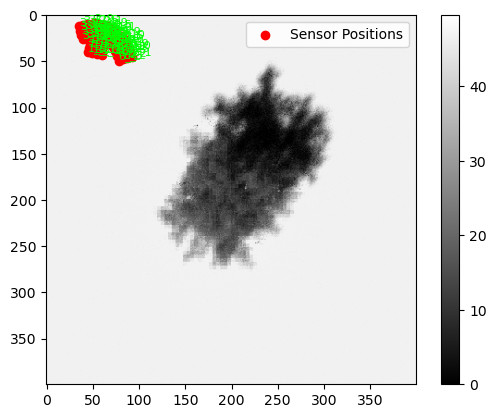

array([[46.77270396, 46.85901058, 46.75625797, ..., 46.79914594,
        46.83059767, 46.79209533],
       [46.83181755, 46.82275009, 46.75836773, ..., 46.83024253,
        46.75869691, 46.7609707 ],
       [46.84141877, 46.78742435, 46.74481755, ..., 46.80306573,
        46.82609124, 46.75986047],
       ...,
       [46.79083883, 46.75608187, 46.75768478, ..., 46.83876353,
        46.79620941, 46.81635497],
       [46.80201831, 46.80265903, 46.82625301, ..., 46.8514639 ,
        46.7880811 , 46.80263578],
       [46.78650159, 46.83170253, 46.78176102, ..., 46.82237354,
        46.86330047, 46.8369393 ]])

In [28]:
#check scene overview (nadir radiance view + sensors positions)
n_sens_size = nadir_sensor_size(os.path.join(simu_path_vox, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
read_sensor(os.path.join(simu_path_vox, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x = scene_size_x, scene_size_y = scene_size_y, res = sensor_res)

In [38]:
# add sensors
add_inside_sensors_perspective(phase_xml_file_path_vox, sensor_positions, center=(0.5*scene_size_x,0.5*scene_size_y), pixel_size = 1)

Output folder copied with index: 2023-08-10_10-01-00. Total time taken so far: 2400.37 seconds


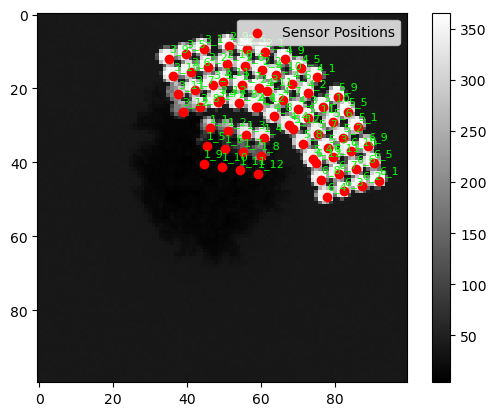

Output folder copied with index: 2023-08-10_10-11-00. Total time taken so far: 4801.15 seconds


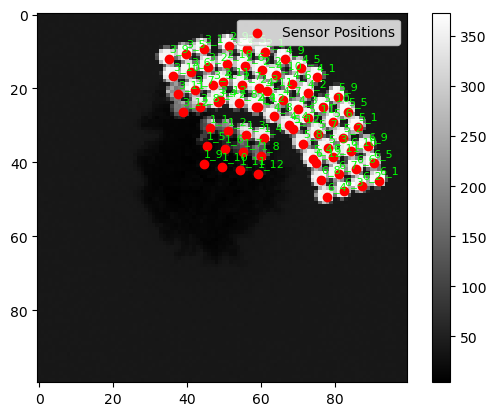

Output folder copied with index: 2023-08-10_10-21-00. Total time taken so far: 7210.56 seconds


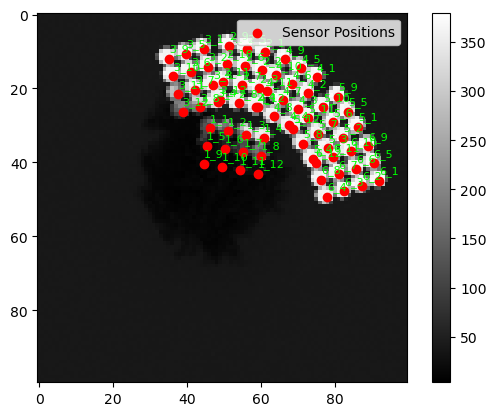

Output folder copied with index: 2023-08-10_10-31-00. Total time taken so far: 9646.62 seconds


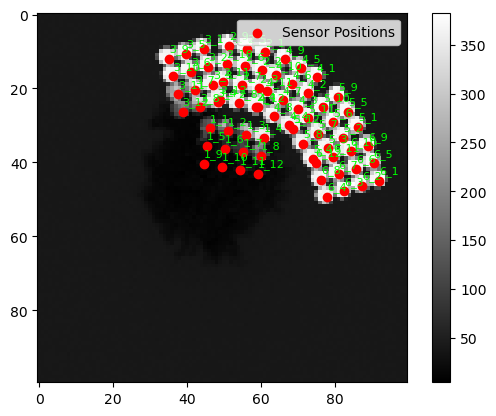

Output folder copied with index: 2023-08-10_10-41-00. Total time taken so far: 12121.52 seconds


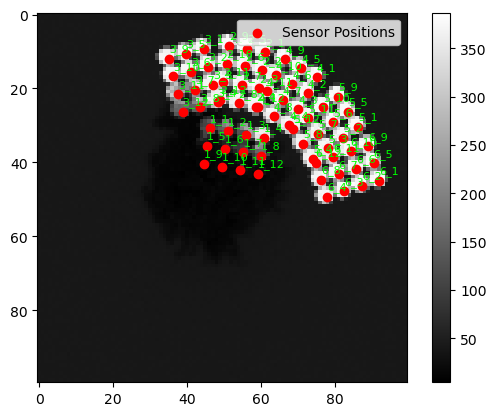

Output folder copied with index: 2023-08-10_10-51-00. Total time taken so far: 14552.54 seconds


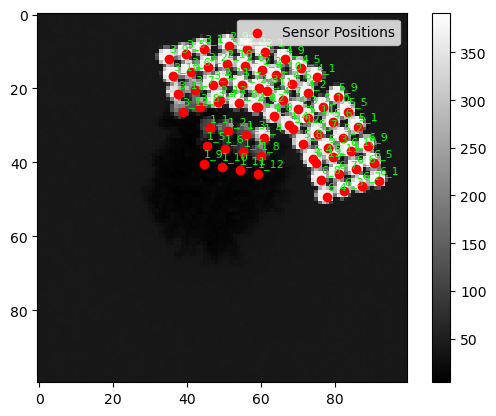

Output folder copied with index: 2023-08-10_11-01-00. Total time taken so far: 16983.57 seconds


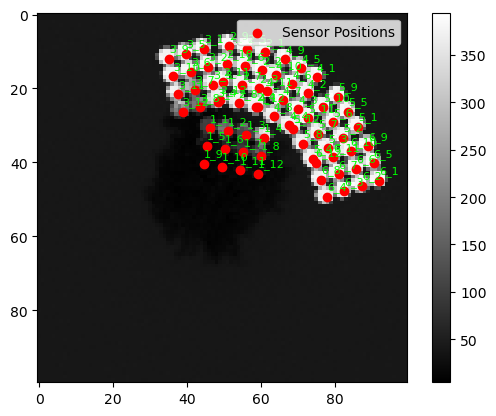

Output folder copied with index: 2023-08-10_11-11-00. Total time taken so far: 19388.48 seconds


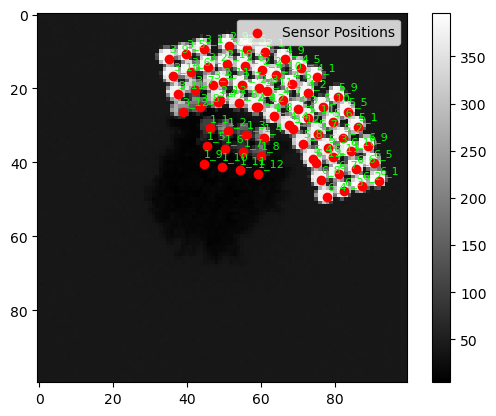

Output folder copied with index: 2023-08-10_11-21-00. Total time taken so far: 21796.76 seconds


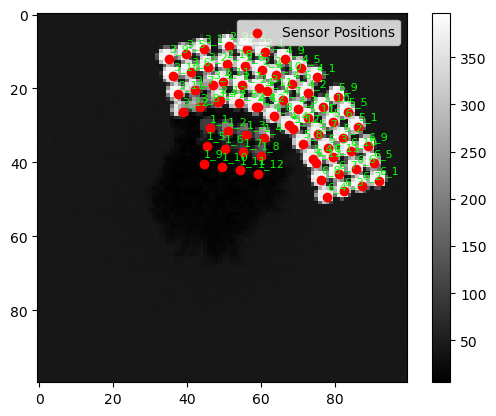

Output folder copied with index: 2023-08-10_11-31-00. Total time taken so far: 24254.74 seconds


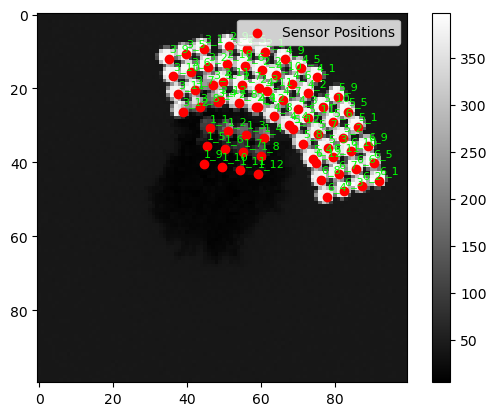

Output folder copied with index: 2023-08-10_11-41-00. Total time taken so far: 26710.18 seconds


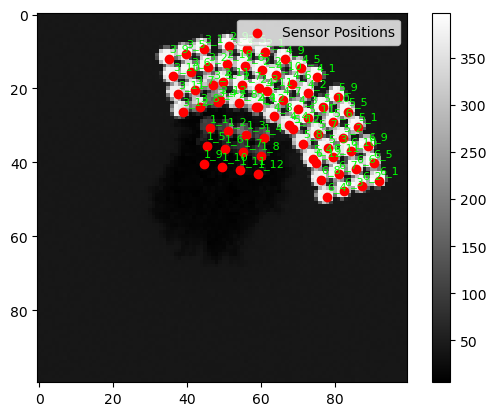

Output folder copied with index: 2023-08-10_11-51-00. Total time taken so far: 29131.46 seconds


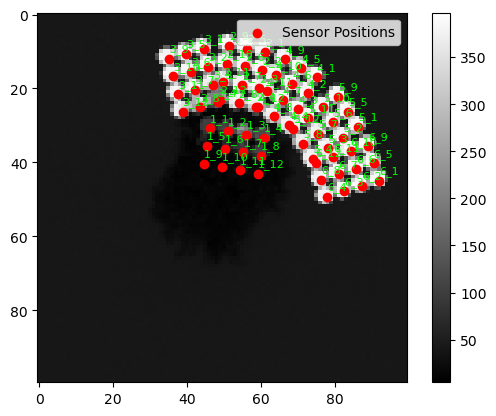

Output folder copied with index: 2023-08-10_12-01-00. Total time taken so far: 31556.88 seconds


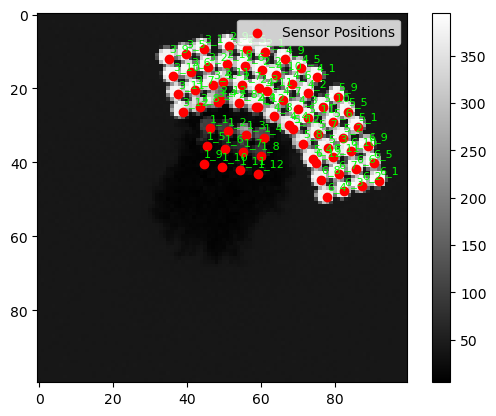

Output folder copied with index: 2023-08-10_12-11-00. Total time taken so far: 33992.67 seconds


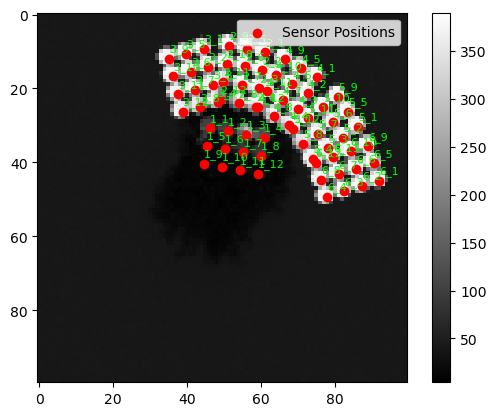

Output folder copied with index: 2023-08-10_12-21-00. Total time taken so far: 36397.49 seconds


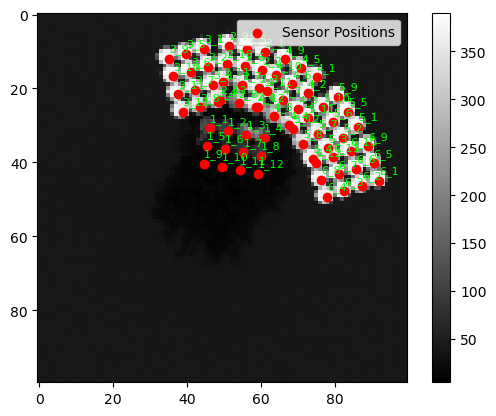

Output folder copied with index: 2023-08-10_12-31-00. Total time taken so far: 38813.95 seconds


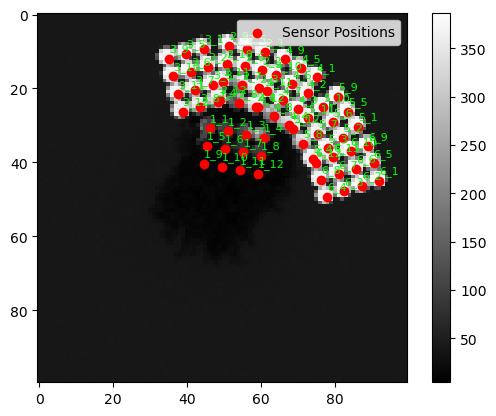

Output folder copied with index: 2023-08-10_12-41-00. Total time taken so far: 41213.21 seconds


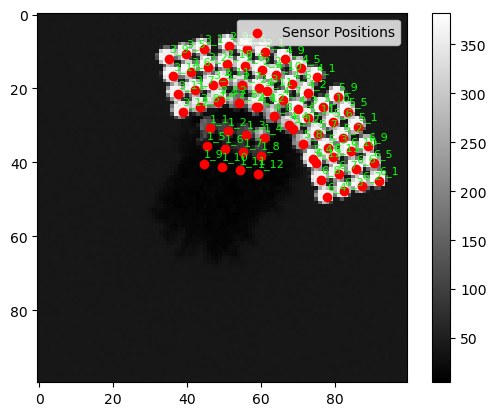

Output folder copied with index: 2023-08-10_12-51-00. Total time taken so far: 43643.79 seconds


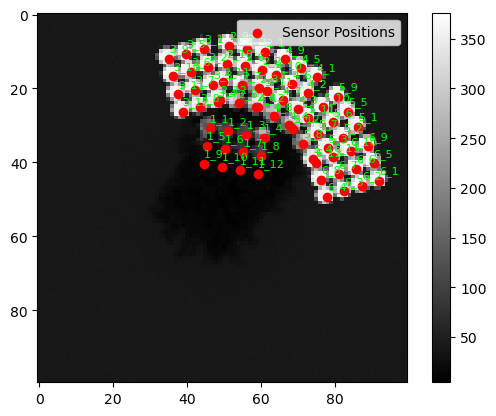

Output folder copied with index: 2023-08-10_13-01-00. Total time taken so far: 46154.94 seconds


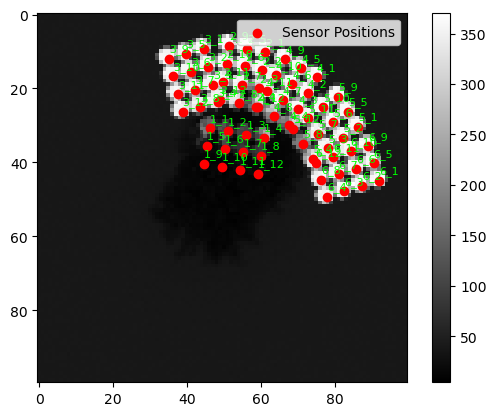

Output folder copied with index: 2023-08-10_13-11-00. Total time taken so far: 48626.84 seconds


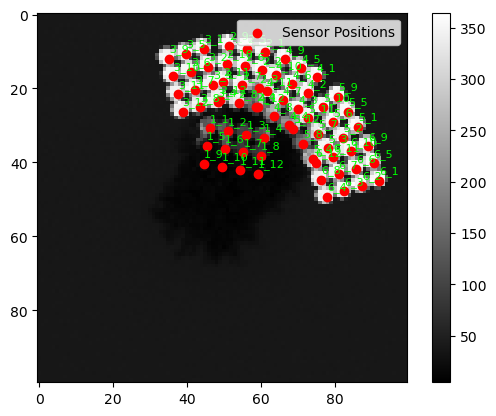

Output folder copied with index: 2023-08-10_13-21-00. Total time taken so far: 51040.98 seconds


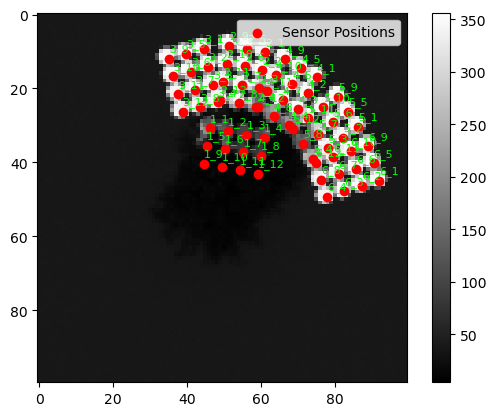

Output folder copied with index: 2023-08-10_13-31-00. Total time taken so far: 53444.13 seconds


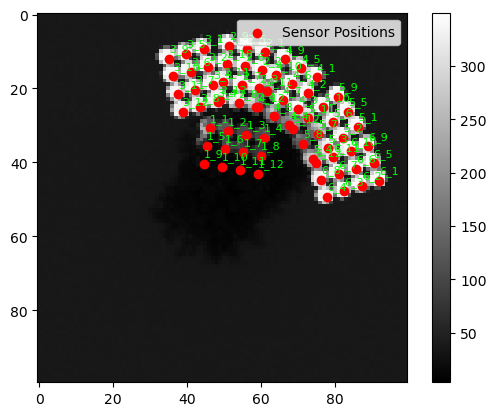

Output folder copied with index: 2023-08-10_13-41-00. Total time taken so far: 55881.82 seconds


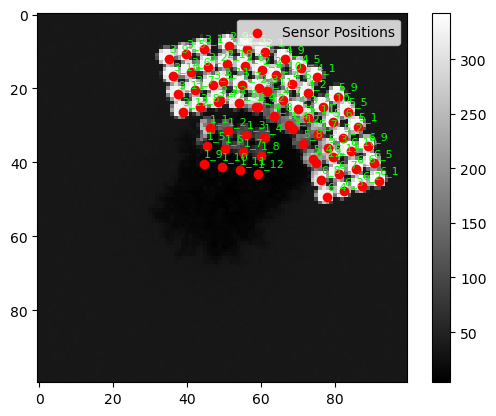

Output folder copied with index: 2023-08-10_13-51-00. Total time taken so far: 58332.98 seconds


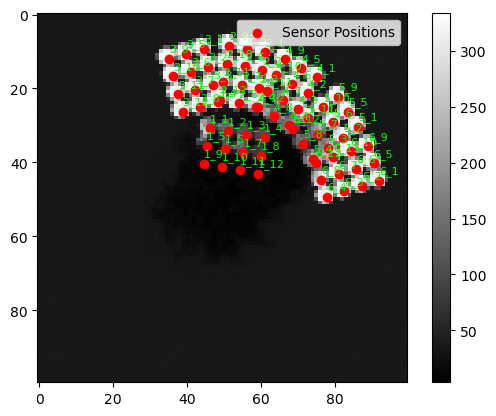

Output folder copied with index: 2023-08-10_14-01-00. Total time taken so far: 60722.91 seconds


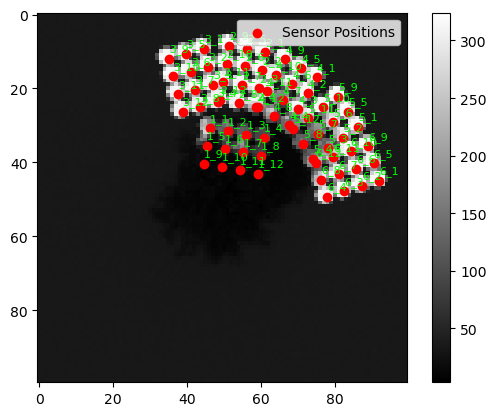

Output folder copied with index: 2023-08-10_14-11-00. Total time taken so far: 63161.66 seconds


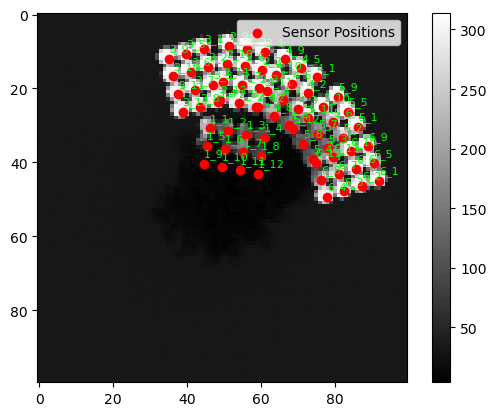

Output folder copied with index: 2023-08-10_14-21-00. Total time taken so far: 65600.83 seconds


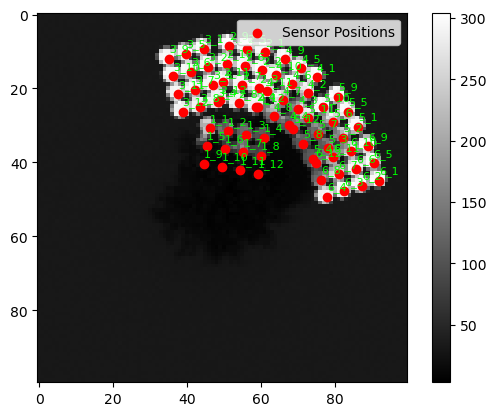

Output folder copied with index: 2023-08-10_14-31-00. Total time taken so far: 68030.06 seconds


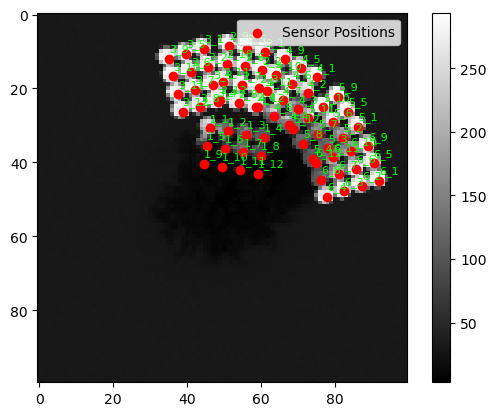

Output folder copied with index: 2023-08-10_14-41-00. Total time taken so far: 70463.51 seconds


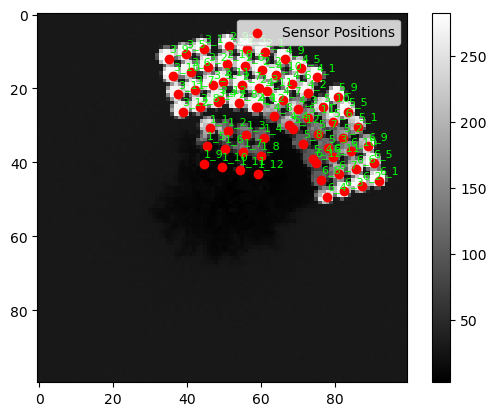

Output folder copied with index: 2023-08-10_14-51-00. Total time taken so far: 72994.03 seconds


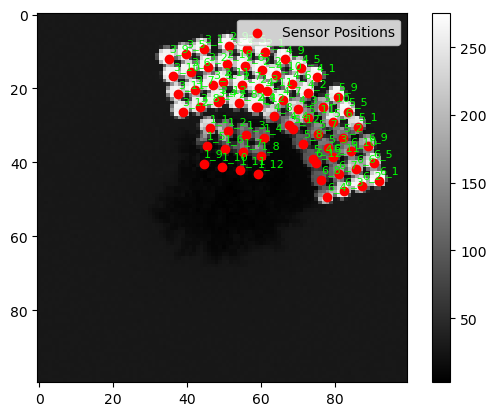

Output folder copied with index: 2023-08-10_15-01-00. Total time taken so far: 75468.27 seconds


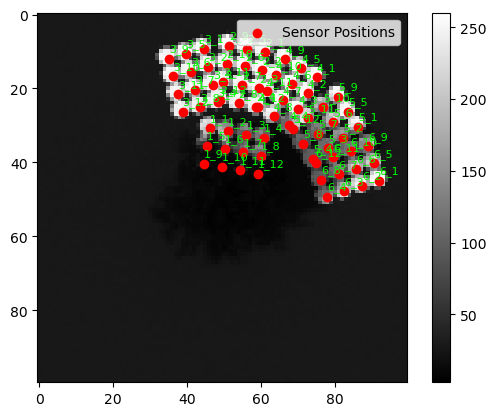

Output folder copied with index: 2023-08-10_15-11-00. Total time taken so far: 77871.09 seconds


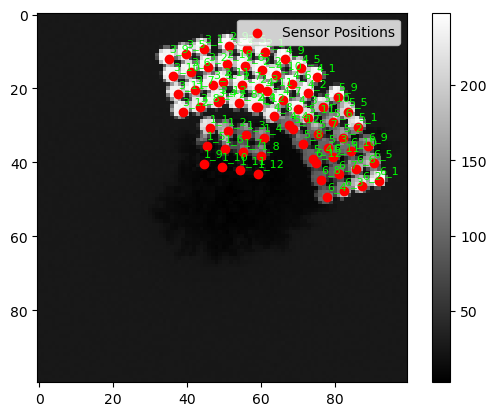

Output folder copied with index: 2023-08-10_15-21-00. Total time taken so far: 80299.18 seconds


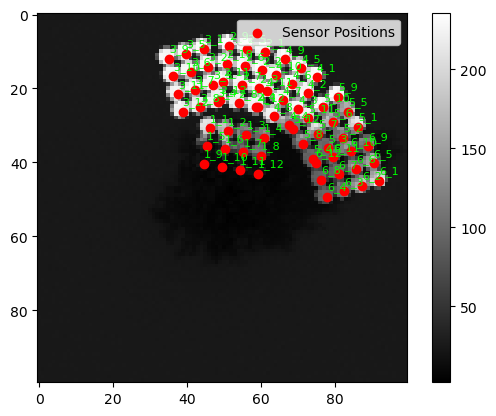

Output folder copied with index: 2023-08-10_15-31-00. Total time taken so far: 82714.77 seconds


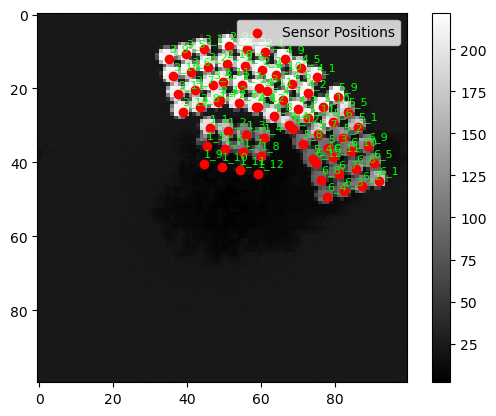

Output folder copied with index: 2023-08-10_15-41-00. Total time taken so far: 85157.81 seconds


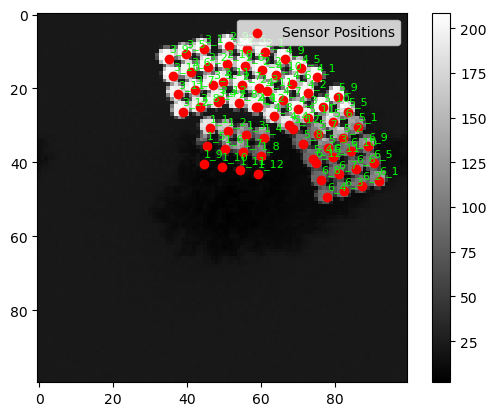

Output folder copied with index: 2023-08-10_15-51-00. Total time taken so far: 87587.20 seconds


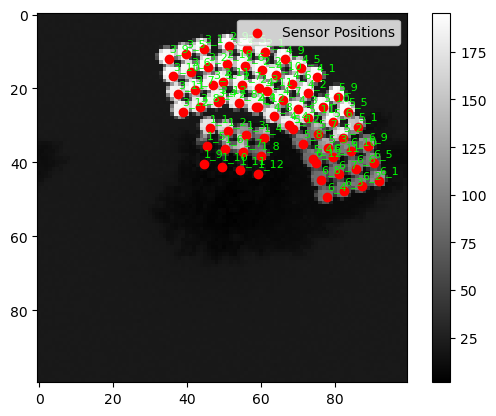

In [39]:
simu = simu_vox

total_elapsed_time = 0

for simtime in time_sequence:
    hour = simtime.hour
    minute = simtime.minute
    second = simtime.second
    
    # Format the datetime object into a string for the index
    index_str = simtime.strftime("%Y-%m-%d_%H-%M-%S")
    change_hour(os.path.join(simu_path_vox, 'input', 'directions.xml'), hour, minute, second)
    save_sensor_data(simu_path_vox, index=index_str)
    n_sens_size = nadir_sensor_size(os.path.join(simu_path_vox, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
    read_sensor(os.path.join(simu_path_vox, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x=scene_size_x, scene_size_y=scene_size_y, res=0.2)

In [41]:
simulation_name = 'Nadir_Images.VOX_1_final_now'
simu_vox_1m = ptd.simulation(simulation_name, empty= True) # create simulation
simu_vox_1m.scene.size = [scene_size_x, scene_size_y]
simu_vox_1m.scene.cell = [res_scene, res_scene]                  # set cell size
simu_vox_1m.sensor.pixel_size=sensor_res                  # for image 
for wvl in [0.55]:
    simu_vox_1m.add.band(wvl=wvl, bw=0.3)             # create a spectral band with specific wavelength (here PAR over one band)
simu_vox_1m.core.maket.set_nodes(latitude=48.00087305, longitude=7.80030941) #gps coordinates for sun location (hier Dietenbach)
simu_vox_1m.core.directions.set_nodes(exactDate=1, timezone = 0, localTime =1, year=2023, month=8, day=10, hour=13, mode=1, nbPointsOnSphere=4)   
simu_vox_1m.core.phase.Phase.AtmosphereRadiativeTransfer.set_nodes(TOAtoBOA=0)

In [42]:
# Define Atmosphere model
simu_vox_1m.core.atmosphere.Atmosphere.set_nodes(aerosolCumulativeModelName="RURALV23",
                                          aerosolsModelName="MIDLATSUM_RURALV23",
                                          hgParametersModelName="RURALV23")

simu_vox_1m.core.atmosphere.Atmosphere.set_nodes(gasCumulativeModelName="MIDLATSUM", gasModelName="MIDLATSUM", temperatureModelName="MIDLATSUM")

In [43]:
# get path for config files
simu_path_vox_1m = simu_vox_1m.simu_dir
phase_xml_file_path_vox_1m = os.path.join(simu_path_vox_1m, 'input', 'phase.xml')

In [44]:
op_foliage = {'type': 'Vegetation',
            'ident': 'turbid_leaf',
            'databaseName': 'Lambertian_vegetation.db',
            'ModelName': 'leaf_deciduous'}
simu_vox_1m.add.optical_property(**op_ground)
simu_vox_1m.scene.ground.OpticalPropertyLink.ident = 'ground'
simu_vox_1m.add.optical_property(**op_target)
simu_vox_1m.add.optical_property(**op_trunk)
simu_vox_1m.add.optical_property(**op_foliage)

In [45]:
# add tree obj
obj_file_path_bark = "P:/Patrick/01_Apfelbaum_Radiative_Transfer/3D_objects/obj_files_rotated/bark_export_R.obj"
# Read OBJ file using OBJtools
obj_bark = ptd.OBJtools.objreader(obj_file_path_bark)

# Get center and dimensions of the object
center_bark = obj_bark.center
dim_bark = obj_bark.dims
# Calculate offsets so object center is in scene center
#x
pos_offset_x_bark = pos_offset_x + (center[0] - center_bark[0])
#y
pos_offset_y_bark = pos_offset_y + (center[1] - center_bark[1])

#z
center_z_bark = center_bark[2]
pos_offset_z_bark = dim_bark[2]*0.5 - center_z_bark

# add .obj
bark = simu_vox_1m.add.object_3d(obj_file_path_bark, xpos=pos_offset_x_bark, zpos=pos_offset_z_bark, ypos=pos_offset_y_bark, xscale=1, yscale =1, zscale=1)
bark.ObjectOpticalProperties.set_nodes(ident = 'trunk', color='trunk')
bark.objectDEMMode = 2
bark.ObjectOpticalProperties.doubleFace=1

In [46]:
# add vox
voxfile = 'P:/Patrick/01_Apfelbaum_Radiative_Transfer/AMAPvox_out/out1/apfelbaum_1_PAD_invert.vox'
vx = -6.5 + pos_offset_y 
vy = -14 + pos_offset_x_inv 
vz = 1.3
new_min_corner = (vy, vx, vz)
modify_voxel_pos(voxfile, voxfile, new_min_corner)

vox_1m = ptd.voxreader.voxel().from_vox(voxfile)
# Convert vox to DART plots 
plots1m = vox_1m.to_plots(reduce_xy=False)
# add an optical property to each plot
plots1m['PLT_OPT_NAME'] = 'turbid_leaf'
# add plots to simulation
simu_vox_1m.add.plots(plots1m)

print("Adjusted min. corner:", new_min_corner)

Updating plot file properties index...
Adjusted min. corner: (5.076699999999999, 4.8728, 1.3)


In [35]:
# Create dictionary for the target_objects
targets_vox = {}

# add target objects to scene
for index, row in sensor_positions.iterrows():
    name = row["Name"]
    x_inv = row["Y"]
    y = row["X"]
    z = 0.01
    target = simu_vox_1m.add.object_3d(target_obj_path, xpos=x_inv, zpos=z, ypos=y, xscale=1, yscale=1, zscale=1, name=name)
    target.ObjectOpticalProperties.doubleFace=1
    target.ObjectOpticalProperties.set_nodes(ident='target')
    targets_vox[name] = target

# Write the simulation (assuming simu is defined elsewhere)
simu_vox_1m.write(overwrite=True)

Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...
Updating plot file properties index...

Plots written in 'C:\Users\PWW-LiDAR\DART\user_data\simulations\Nadir_Images.VOX_1_final_now\input\plots.txt'


In [47]:
simu_vox_1m.write(overwrite=True)

Updating optical properties indexes...
Updating thermal properties indexes...
Updating spectral multiplicative factors...
Updating band numbers...
Updating plot file properties index...

Plots written in 'C:\Users\PWW-LiDAR\DART\user_data\simulations\Nadir_Images.VOX_1_final_now\input\plots.txt'


In [48]:
# change brf product type to also include radiance
tree = ET.parse(phase_xml_file_path_vox_1m)
root = tree.getroot()
element = root.find(".//BrfProductsProperties[@luminanceProducts]")
if element is not None:
    element.set('luminanceProducts', '1')

# irradiance is calculated for brf products (3 = industry standard )
element2 = root.find(".//BrfProductsProperties[@projection]")
if element2 is not None:
    element2.set('projection', '3')

tree.write(phase_xml_file_path_vox_1m)

In [49]:
#run base simulation once (this has to happen to later add the sensors, dont know why)
simu_vox_1m.run.full()

True

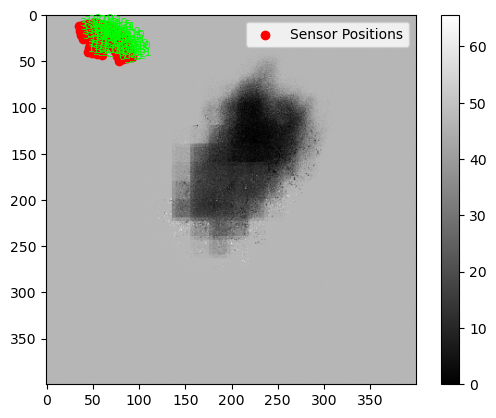

array([[46.80170022, 46.83626123, 46.75576281, ..., 46.79170631,
        46.77207543, 46.78785175],
       [46.79819511, 46.82275009, 46.77015933, ..., 46.79055651,
        46.82960039, 46.7609707 ],
       [46.80685911, 46.7525257 , 46.74481755, ..., 46.76959019,
        46.89897777, 46.80858799],
       ...,
       [46.7949441 , 46.78580768, 46.75768478, ..., 46.77377004,
        46.79108906, 46.7547581 ],
       [46.82349953, 46.79307299, 46.79982574, ..., 46.7878203 ,
        46.78473179, 46.80946313],
       [46.7906723 , 46.83971471, 46.78598382, ..., 46.8457018 ,
        46.81765278, 46.80497316]])

In [50]:
#check scene overview (nadir radiance view + sensors positions)
n_sens_size = nadir_sensor_size(os.path.join(simu_path_vox_1m, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
read_sensor(os.path.join(simu_path_vox_1m, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x = scene_size_x, scene_size_y = scene_size_y, res = 0.2)

In [46]:
add_inside_sensors_perspective(phase_xml_file_path_vox_1m, sensor_positions, center=(0.5*scene_size_x,0.5*scene_size_y), pixel_size = 1)

Output folder copied with index: 2023-08-10_10-01-00. Total time taken so far: 630.04 seconds


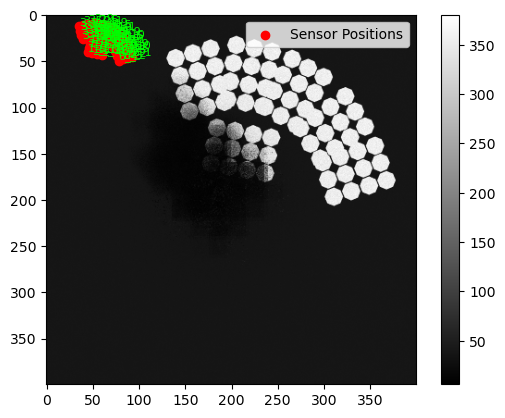

Output folder copied with index: 2023-08-10_10-11-00. Total time taken so far: 1279.38 seconds


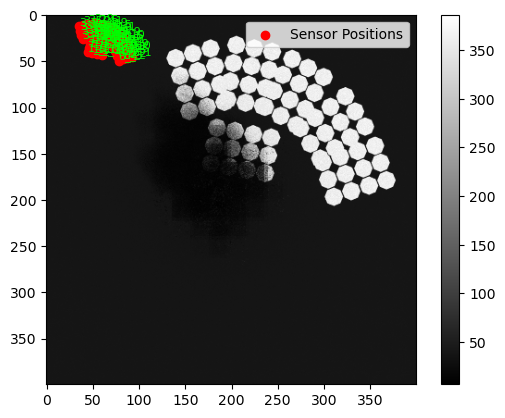

Output folder copied with index: 2023-08-10_10-21-00. Total time taken so far: 1936.51 seconds


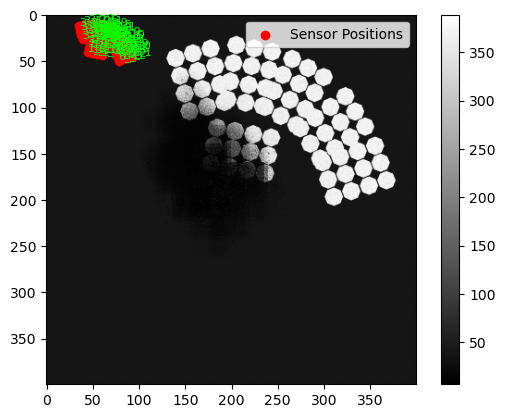

Output folder copied with index: 2023-08-10_10-31-00. Total time taken so far: 2585.52 seconds


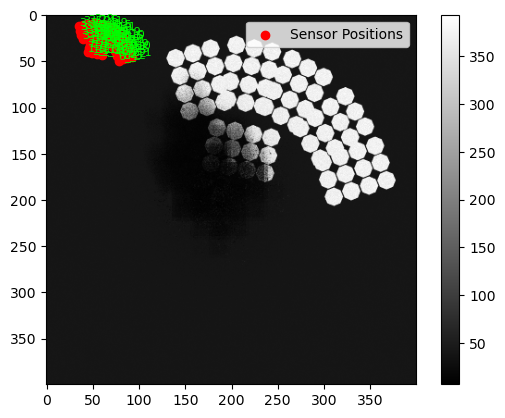

Output folder copied with index: 2023-08-10_10-41-00. Total time taken so far: 3245.86 seconds


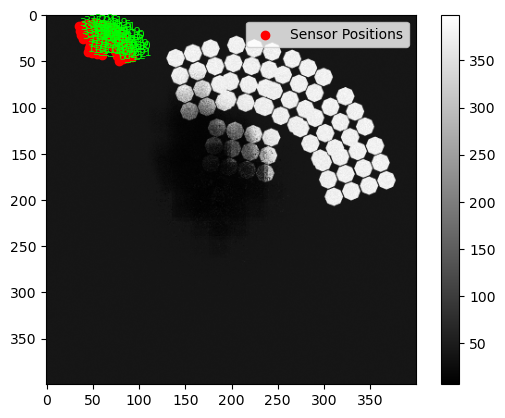

Output folder copied with index: 2023-08-10_10-51-00. Total time taken so far: 3902.28 seconds


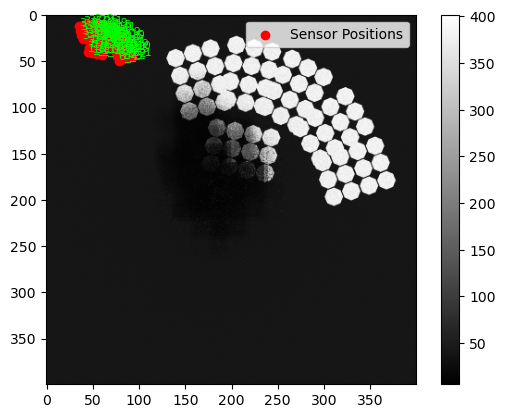

Output folder copied with index: 2023-08-10_11-01-00. Total time taken so far: 4550.06 seconds


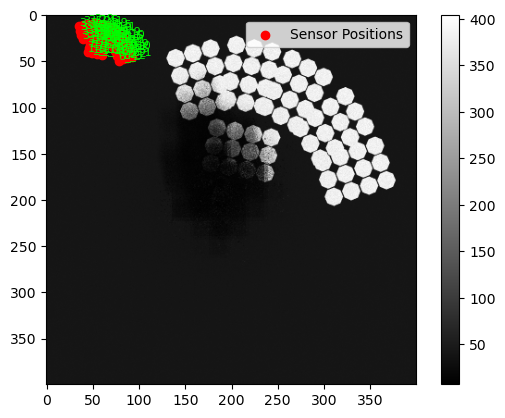

Output folder copied with index: 2023-08-10_11-11-00. Total time taken so far: 5195.51 seconds


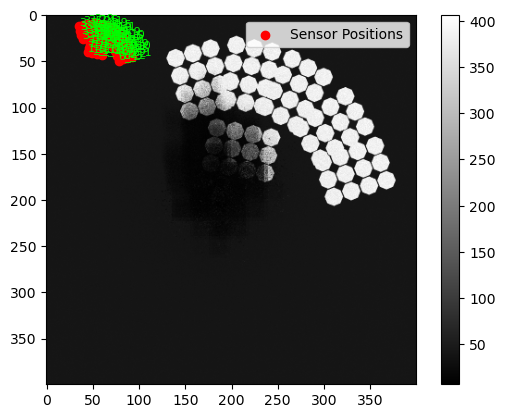

Output folder copied with index: 2023-08-10_11-21-00. Total time taken so far: 5832.27 seconds


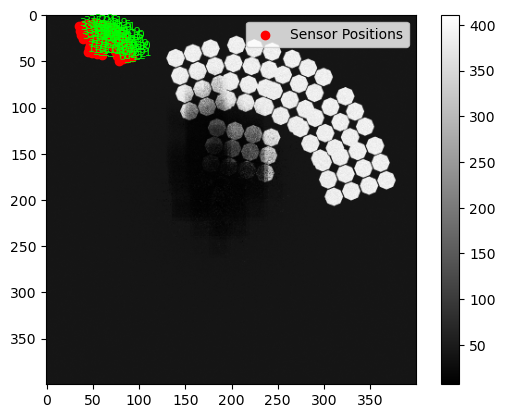

Output folder copied with index: 2023-08-10_11-31-00. Total time taken so far: 6467.22 seconds


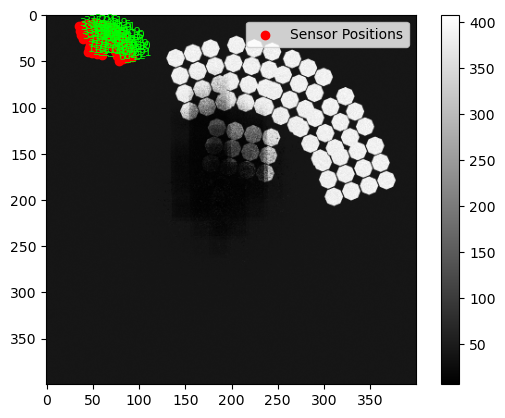

Output folder copied with index: 2023-08-10_11-41-00. Total time taken so far: 7109.90 seconds


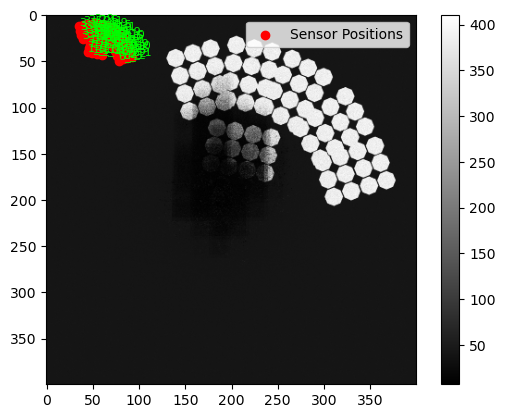

Output folder copied with index: 2023-08-10_11-51-00. Total time taken so far: 7760.81 seconds


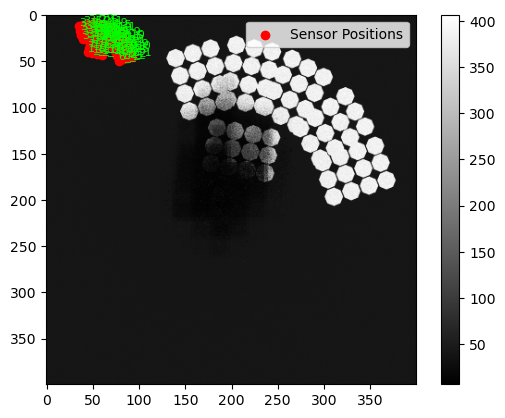

Output folder copied with index: 2023-08-10_12-01-00. Total time taken so far: 8415.79 seconds


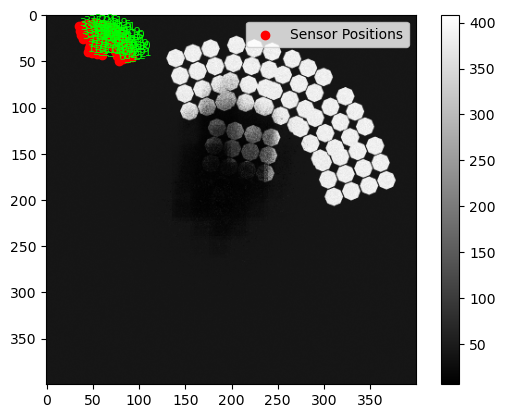

Output folder copied with index: 2023-08-10_12-11-00. Total time taken so far: 9060.52 seconds


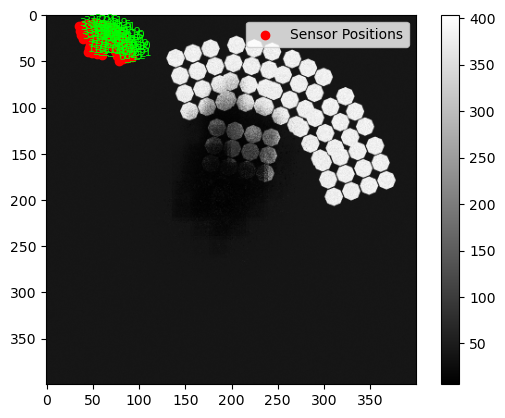

Output folder copied with index: 2023-08-10_12-21-00. Total time taken so far: 9706.12 seconds


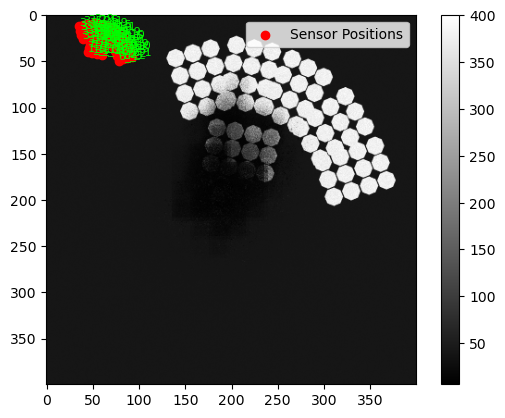

Output folder copied with index: 2023-08-10_12-31-00. Total time taken so far: 10360.87 seconds


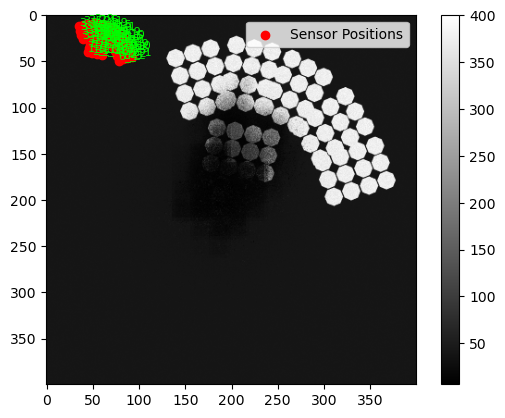

Output folder copied with index: 2023-08-10_12-41-00. Total time taken so far: 10996.53 seconds


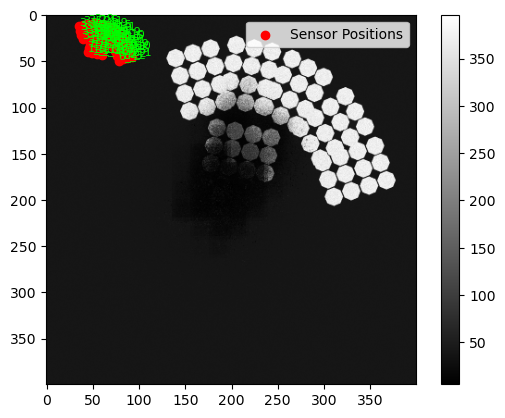

Output folder copied with index: 2023-08-10_12-51-00. Total time taken so far: 11643.10 seconds


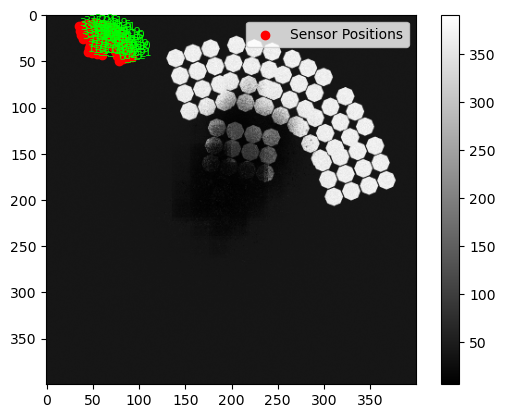

Output folder copied with index: 2023-08-10_13-01-00. Total time taken so far: 12297.00 seconds


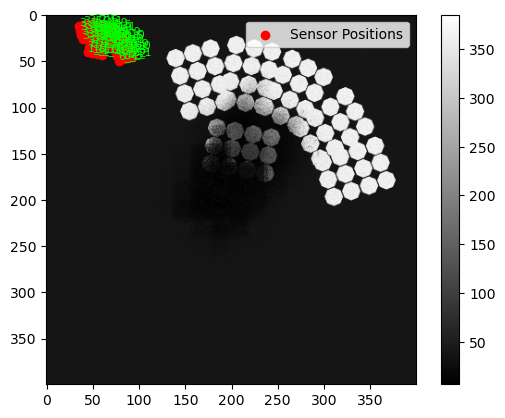

Output folder copied with index: 2023-08-10_13-11-00. Total time taken so far: 12947.42 seconds


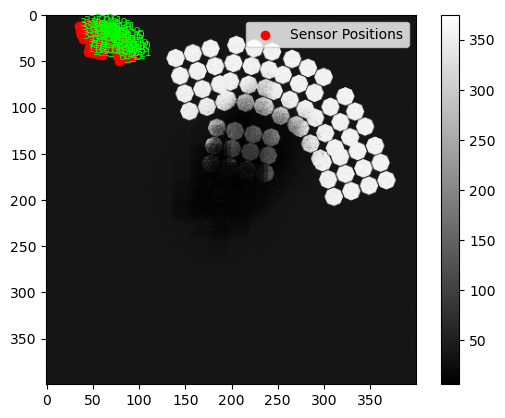

Output folder copied with index: 2023-08-10_13-21-00. Total time taken so far: 13620.54 seconds


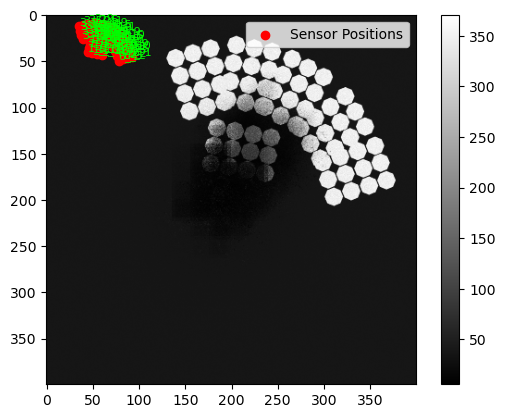

Output folder copied with index: 2023-08-10_13-31-00. Total time taken so far: 14262.50 seconds


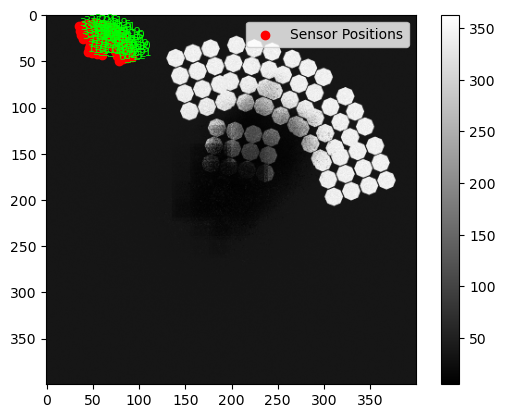

Output folder copied with index: 2023-08-10_13-41-00. Total time taken so far: 14901.12 seconds


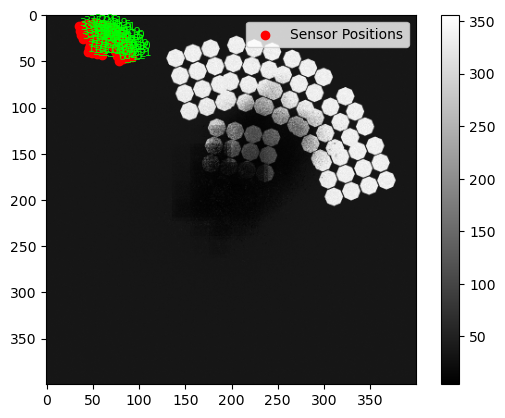

Output folder copied with index: 2023-08-10_13-51-00. Total time taken so far: 15547.71 seconds


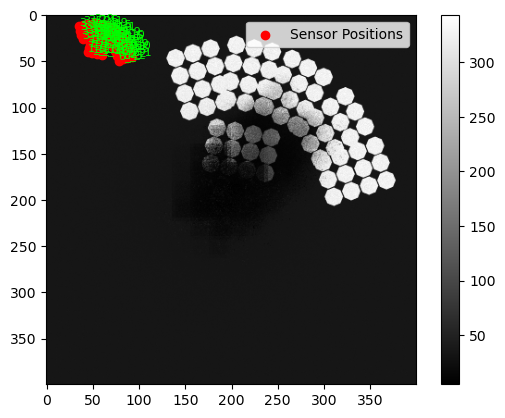

Output folder copied with index: 2023-08-10_14-01-00. Total time taken so far: 16184.36 seconds


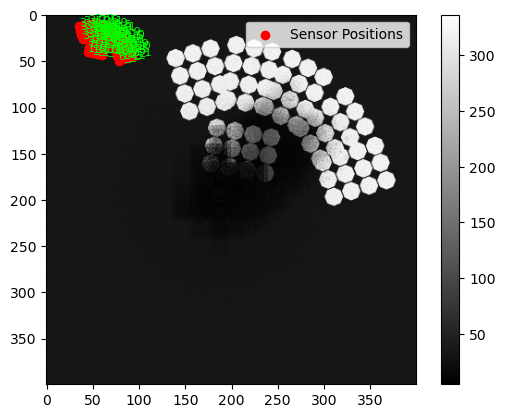

Output folder copied with index: 2023-08-10_14-11-00. Total time taken so far: 16825.04 seconds


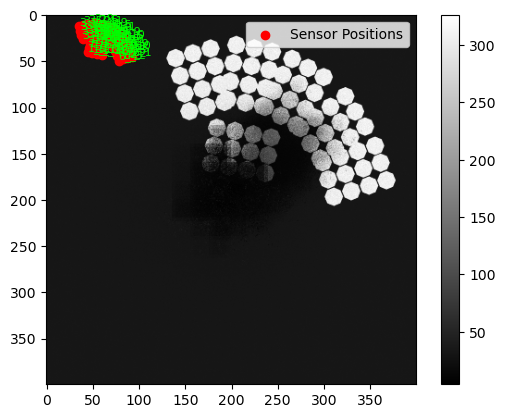

Output folder copied with index: 2023-08-10_14-21-00. Total time taken so far: 17476.62 seconds


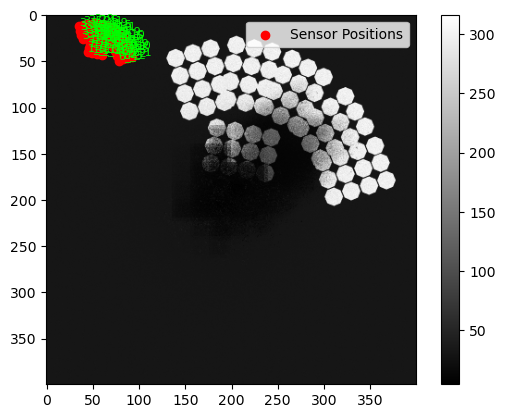

Output folder copied with index: 2023-08-10_14-31-00. Total time taken so far: 18132.95 seconds


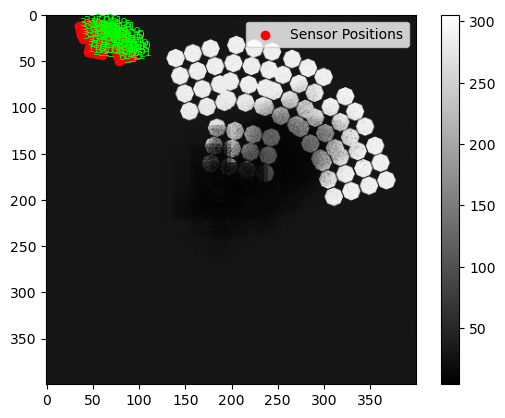

Output folder copied with index: 2023-08-10_14-41-00. Total time taken so far: 18797.76 seconds


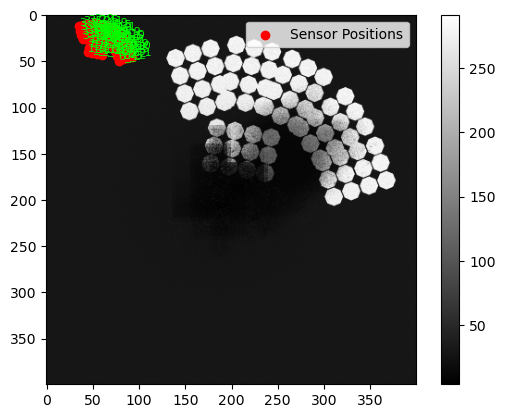

Output folder copied with index: 2023-08-10_14-51-00. Total time taken so far: 19437.33 seconds


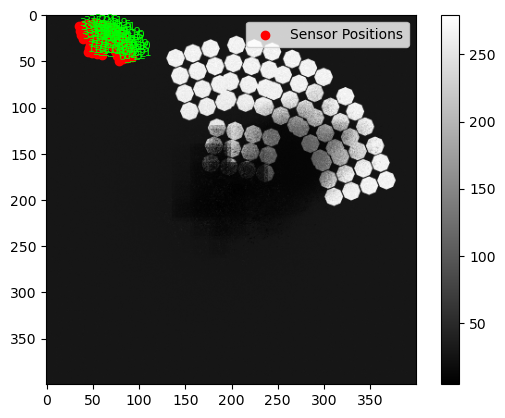

Output folder copied with index: 2023-08-10_15-01-00. Total time taken so far: 20075.44 seconds


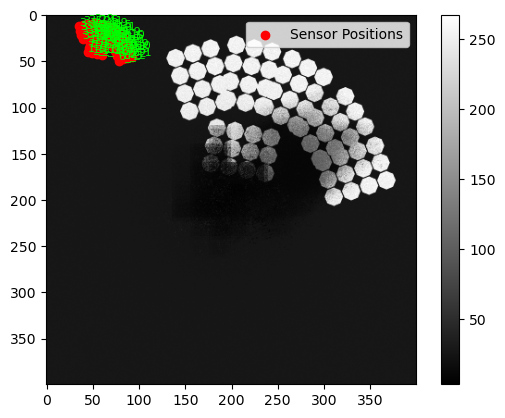

Output folder copied with index: 2023-08-10_15-11-00. Total time taken so far: 20713.06 seconds


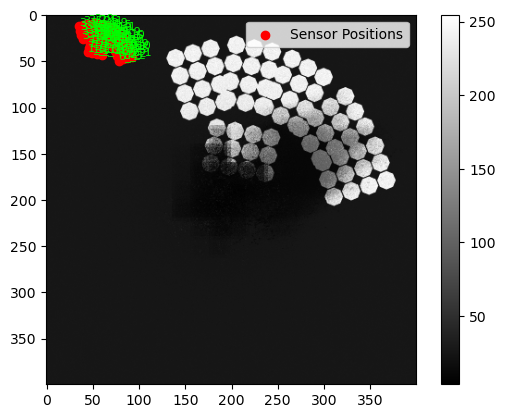

In [47]:
simu = simu_vox_1m

total_elapsed_time = 0

for simtime in time_sequence:
    hour = simtime.hour
    minute = simtime.minute
    second = simtime.second
    
    # Format the datetime object into a string for the index
    index_str = simtime.strftime("%Y-%m-%d_%H-%M-%S")
    change_hour(os.path.join(simu_path_vox_1m, 'input', 'directions.xml'), hour, minute, second)
    save_sensor_data(simu_path_vox_1m, index=index_str)
    n_sens_size = nadir_sensor_size(os.path.join(simu_path_vox_1m, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mpr'))
    read_sensor(os.path.join(simu_path_vox_1m, 'output\BAND0\Radiance\ITERX\IMAGES_DART\ima001_VZ=000_0_VA=000_0.mp#'), size=n_sens_size, sensor_df=sensor_positions, scene_size_x=scene_size_x, scene_size_y=scene_size_y, res=0.2)